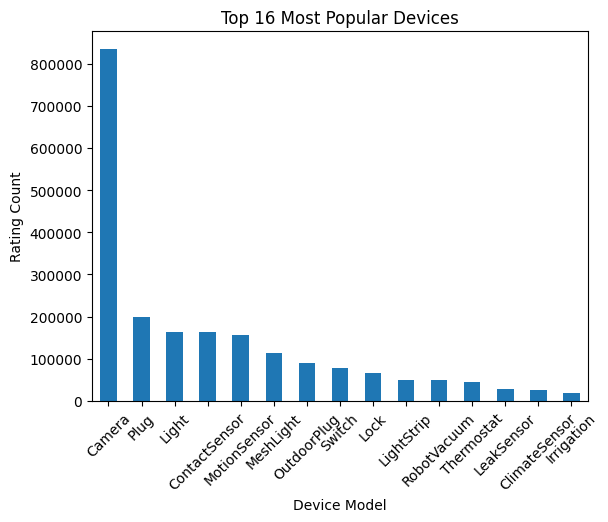

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
 camera
 motion
 detects
 turn
 detection
 pet
 notifications
 siren
 sound
 person
Cluster 1:
 switch
 press
 double
 hold
 turn
 triple
 meshlight
 set
 plug
 light
Cluster 2:
 clear
 motionsensor
 light
 turn
 plug
 meshlight
 switch
 set
 lightstrip
 brightness
Cluster 3:
 plug
 turn
 detects
 motion
 turns
 camera
 motionsensor
 person
 senses
 climatesensor
Cluster 4:
 single
 press
 switch
 meshlight
 turn
 light
 plug
 lightstrip
 outdoorplug
 camera
Cluster 5:
 light
 motion
 motionsensor
 detects
 turn
 set
 meshlight
 brightness
 color
 camera
Cluster 6:
 unmute
 notifications
 cloud
 camera
 detects
 pet
 motion
 person
 sound
 mute
Cluster 7:
 upload
 video
 short
 cloud
 camera
 detects
 motion
 person
 opens
 contactsensor
Cluster 8:
 contactsensor
 opens
 turn
 light
 closes
 plug
 camera
 set
 closed
 meshlight
Cluster 9:
 person
 camera
 detects
 turn
 siren
 meshlight
 light
 set
 notifications
 color
Cluster 0:
 camera
 motion
 detects
 turn
 detection
 p

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Function to load and merge data
def load_and_merge_data(rule_file, device_file):
    rule_df = pd.read_csv(rule_file)
    device_df = pd.read_csv(device_file)
    return pd.merge(rule_df.drop(columns=['rule']), device_df, on='user_id', how='inner')

# Function to calculate ratings and find popular devices
def calculate_ratings_and_popular_devices(data):
    rating_counts = data.groupby(['user_id', 'device_model', 'trigger_device_id', 'trigger_state_id', 'action_id', 'action_device_id']).size().reset_index(name='count')
    max_count = rating_counts['count'].max()
    rating_counts['Rating'] = (rating_counts['count'] / max_count) * 5
    popular_devices = rating_counts['device_model'].value_counts().head(16)
    return data.merge(rating_counts[['user_id', 'device_model', 'trigger_device_id', 'trigger_state_id', 'action_id', 'action_device_id', 'Rating']], on=['user_id', 'device_model', 'trigger_device_id', 'trigger_state_id', 'action_id', 'action_device_id'], how='left'), popular_devices

# Function to plot popular devices
def plot_popular_devices(popular_devices):
    popular_devices.plot(kind="bar")
    plt.xlabel('Device Model')
    plt.ylabel('Rating Count')
    plt.title('Top 16 Most Popular Devices')
    plt.xticks(rotation=45)
    plt.show()

# Function to perform dimensionality reduction with Truncated SVD
def perform_dimensionality_reduction(utility_matrix):
    svd = TruncatedSVD(n_components=10, random_state=42)
    decomposed_matrix = svd.fit_transform(utility_matrix.T)
    return decomposed_matrix

# Function to calculate correlation matrix
def calculate_correlation_matrix(decomposed_matrix):
    return np.corrcoef(decomposed_matrix)

# Function to recommend devices for a specific device
def recommend_devices(device_name, correlation_matrix, device_names):
    model_device = device_names.index(device_name)
    correlation_model_device = correlation_matrix[model_device]
    recommend = [device for idx, device in enumerate(device_names) if correlation_model_device[idx] > 0 and device != device_name]
    return recommend[:9]

# Function to perform text-based clustering
def perform_text_based_clustering(data):
    combined_text = data['trigger_device'] + ' ' + data['trigger_state'] + ' ' + data['action'] + ' ' + data['action_device']
    vectorizer = TfidfVectorizer(stop_words='english')
    X1 = vectorizer.fit_transform(combined_text)
    return X1, vectorizer

# Function to perform K-Means clustering
def perform_kmeans_clustering(X1, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    y_kmeans = kmeans.fit_predict(X1)
    return kmeans, y_kmeans

# Function to print top terms per cluster
def print_top_terms_per_cluster(model, vectorizer, true_k):
    terms = vectorizer.get_feature_names_out()
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    for i in range(true_k):
        print(f"Cluster {i}:")
        for ind in order_centroids[i, :10]:
            print(f' {terms[ind]}')

# Function to show recommendations for a rule
def show_recommendations_for_rule(rule, model, vectorizer):
    Y = vectorizer.transform([rule])
    prediction = model.predict(Y)
    print_top_terms_per_cluster(model, vectorizer, 10)
    print(f"Recommendations for '{rule}': Cluster {prediction[0]}")

# Function to generate ground truth rules for users
def generate_ground_truth_rules(num_users):
    ground_truth_rules = {}
    for i in range(1, num_users + 1):
        ground_truth_rule = f"ground_truth_rule_{np.random.randint(1, 101)}"
        ground_truth_rules[f"user{i}"] = ground_truth_rule
    return ground_truth_rules

# Function to generate recommendations for users and calculate MRR
def calculate_mean_reciprocal_rank(users, ground_truth_rules):
    total_mrr = 0.0
    for user_id in users:
        ground_truth_rule = ground_truth_rules[user_id]
        recommendations = generate_recommendations(user_id)
        mrr = calculate_mrr(ground_truth_rule, recommendations)
        total_mrr += mrr
    return total_mrr / len(users)

# Function to generate recommendations for a user
def generate_recommendations(user_id):
    all_rules = [f"ground_truth_rule_{i}" for i in range(1, 101)]
    np.random.shuffle(all_rules)
    return all_rules[:50]

# Function to calculate MRR for a user
def calculate_mrr(ground_truth_rule, recommendations):
    if ground_truth_rule in recommendations:
        rank = recommendations.index(ground_truth_rule) + 1
        return 1.0 / rank
    else:
        return 0.0

if __name__ == "__main__":
    # Load and merge data
    merged_data = load_and_merge_data("train_rule.csv", "train_device.csv")

    # Calculate ratings and find popular devices
    merged_data, popular_devices = calculate_ratings_and_popular_devices(merged_data)

    # Plot popular devices
    plot_popular_devices(popular_devices)

    # Train-test split
    train_df, test_df = train_test_split(merged_data, test_size=0.2, random_state=42)

    # Create a utility matrix
    utility_matrix = train_df.pivot_table(values='Rating', index='user_id', columns='device_model', fill_value=0)

    # Perform dimensionality reduction with Truncated SVD
    decomposed_matrix = perform_dimensionality_reduction(utility_matrix)

    # Calculate correlation matrix
    correlation_matrix = calculate_correlation_matrix(decomposed_matrix)

    # Recommend devices for a specific device
    recommended_devices = recommend_devices("Plug", correlation_matrix, list(utility_matrix.columns))

    # Text-based clustering
    X1, vectorizer = perform_text_based_clustering(merged_data)

    # Perform K-Means clustering
    kmeans, y_kmeans = perform_kmeans_clustering(X1, n_clusters=10)

    # Print top terms per cluster
    print_top_terms_per_cluster(kmeans, vectorizer, 10)

    # Show recommendations for a specific rule
    show_recommendations_for_rule("light", kmeans, vectorizer)

    # Generate ground truth rules for users
    ground_truth_rules = generate_ground_truth_rules(num_users=1000000)

    # Calculate mean reciprocal rank (MRR) for the entire dataset
    users = [f"user{i}" for i in range(1, 1000001)]
    mean_mrr = calculate_mean_reciprocal_rank(users, ground_truth_rules)
    print(f"Mean Reciprocal Rank (MRR) for the entire dataset: {mean_mrr:.4f}")

    # Generate ground truth rules for test users
    ground_truth_rules = generate_ground_truth_rules(num_users=len(test_df))

    # Calculate MRR for test users
    test_users = [f"user{i}" for i in test_df['user_id']]
    mean_mrr_test = calculate_mean_reciprocal_rank(test_users, ground_truth_rules)
    print(f"Mean Reciprocal Rank (MRR) for the test dataset: {mean_mrr_test:.4f}")